# 1. Data collection notebook

### Objectives
Compile a dataset containing historical events (relavant to industry) with historical and the most recent market data for 3 leading Li mining companies.

### Inputs
* Market data from yfinance
* Library of historical events (generated by ChatGPT)

### Outputs
`outputs\nb1_market_index_with_historical.feather`

### Notes/comments

<hr>

### Import required libraries

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings  # Filter warnings from yfinance
import matplotlib.pyplot as plt
from datetime import date, timedelta

#### Config, adjust settings

In [4]:
warnings.simplefilter('ignore') # suppress verbosity from yfinance library

#### Get stock data

In [5]:
tickers = ['ALB', 'SQM', 'PLL']  # We drop 'LAC' since it is relatively young company
start_date = "2010-01-01"
# end_date = "2025-04-04"
today = date.today()
# Go back to the last Sunday
days_since_sunday = (today.weekday() + 1) % 7
last_sunday = today - timedelta(days=days_since_sunday)
end_date = last_sunday.strftime("%Y-%m-%d")
# Download weekly adjusted close prices
def get_weekly_data(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, interval='1wk')['Close']
    df = df.dropna(how='all')  # drop rows with all NaNs
    return df

price_df = get_weekly_data(tickers, start_date, end_date)
price_df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Ticker,ALB,PLL,SQM
Date,,,
2010-01-01,30.474361,NaN,23.024271
2010-01-08,30.554939,NaN,23.362701
2010-01-15,29.910326,NaN,22.221861
2010-01-22,29.362389,NaN,20.371412
2010-01-29,28.516333,NaN,19.465281


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


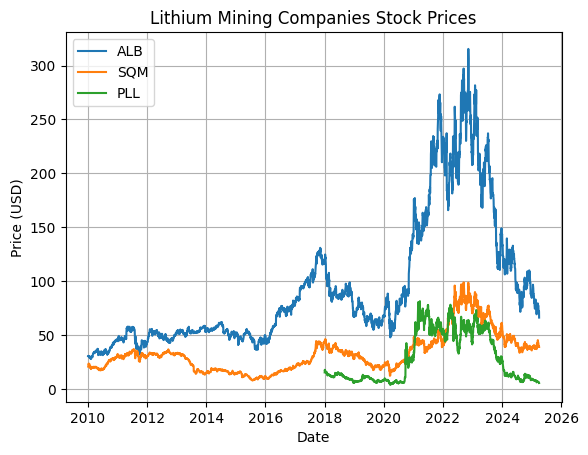

In [6]:
# Fetch and plot data
for ticker in tickers:
    data = yf.download(ticker, start='2010-01-01', end='2025-04-04')
    plt.plot(data['Close'], label=ticker)

plt.title("Lithium Mining Companies Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig('../assets/img/mining_comp_stock_price.png', dpi=300)
plt.show()


In [7]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1178 entries, 2010-01-01 to 2025-04-11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ALB     798 non-null    float64
 1   PLL     380 non-null    float64
 2   SQM     798 non-null    float64
dtypes: float64(3)
memory usage: 36.8 KB


#### Calculate weekly return

In [8]:
# Calculate weekly returns for each ticker
returns_df = price_df.pct_change().dropna()
returns_df.head()


Ticker,ALB,PLL,SQM
Date,,,
2018-01-05,0.034326,0.000000,0.035321
2018-01-08,0.000000,-0.032539,0.000000
2018-01-12,-0.124583,0.000000,-0.076369
2018-01-15,0.000000,-0.070871,0.000000
2018-01-19,-0.008566,0.000000,-0.034226


#### Create a lithium sentiment index

In [9]:
# Simple average across all 3 tickers. This line creates a synthetic sentiment index that rises or falls depending on the average performance of the stocks.
returns_df['Lithium_Index'] = returns_df.mean(axis=1)


#### Convert sentiment into Bullish/Bearish labels (for classification)

In [10]:
returns_df['Sentiment_Label'] = returns_df['Lithium_Index'].apply(lambda x: 1 if x > 0 else 0)


In [11]:
returns_df.head()

Ticker,ALB,PLL,SQM,Lithium_Index,Sentiment_Label
Date,,,,,
2018-01-05,0.034326,0.000000,0.035321,0.023216,1
2018-01-08,0.000000,-0.032539,0.000000,-0.010846,0
2018-01-12,-0.124583,0.000000,-0.076369,-0.066984,0
2018-01-15,0.000000,-0.070871,0.000000,-0.023624,0
2018-01-19,-0.008566,0.000000,-0.034226,-0.014264,0


In [12]:
returns_df['Sentiment_Label'].unique()  # Sentiment label: 1 - Bullish, 0 - Bearish

array([1, 0])

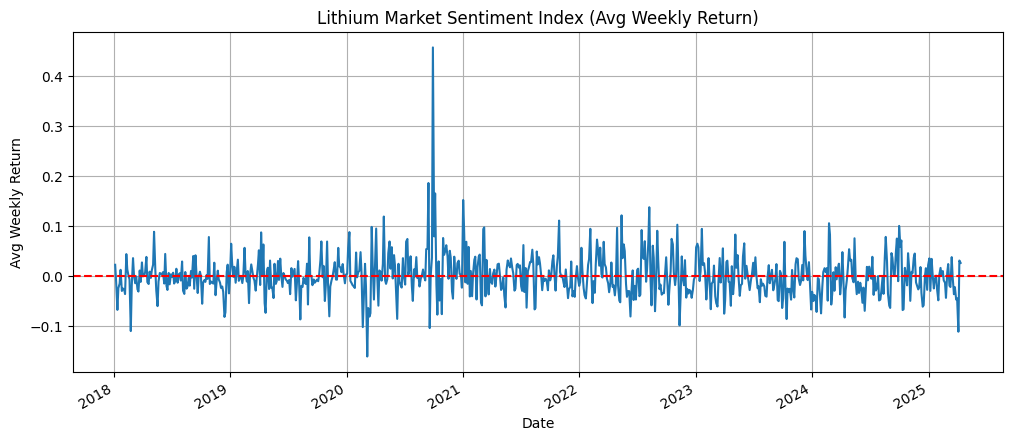

In [13]:
returns_df['Lithium_Index'].plot(figsize=(12, 5), title='Lithium Market Sentiment Index (Avg Weekly Return)')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Avg Weekly Return")
plt.grid(True)
plt.show()


#### Turn returns into a Lithium market index level

In [14]:
# Start index at 100 (like many indices do)
returns_df['Lithium_Market_Index'] = (1 + returns_df['Lithium_Index']).cumprod() * 100


So now:
* The index starts at 100
* If the average weekly return is positive, the index goes up; if negative, it drops
* It mimics the feel of a real price index over time — just based on the lithium sentiment

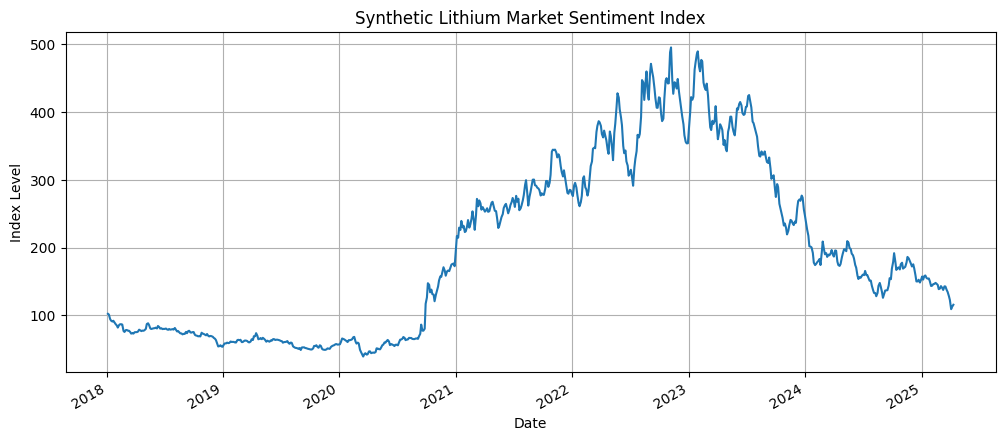

In [15]:
returns_df['Lithium_Market_Index'].plot(figsize=(12,5), title="Synthetic Lithium Market Sentiment Index")
plt.ylabel("Index Level")
plt.grid(True)
plt.show()


In [16]:
returns_df.tail()

Ticker,ALB,PLL,SQM,Lithium_Index,Sentiment_Label,Lithium_Market_Index
Date,,,,,,
2025-03-28,-0.110368,0.000000,-0.028832,-0.046400,0,128.346294
2025-03-31,0.000000,-0.130827,0.000000,-0.043609,0,122.749238
2025-04-04,-0.177293,0.000000,-0.154529,-0.110608,0,109.172249
2025-04-07,0.000000,0.095156,0.000000,0.031719,1,112.635035
2025-04-11,0.035825,0.000000,0.045018,0.026948,1,115.670296


### Build a library of historical events:

There is no direct way in yfinance itself to “attach” historical events to a stock’s price data. Typically, you would pull the historical price data using yfinance and then merge or annotate this data with your own external list of events (e.g., earnings releases, product announcements, geopolitical events, etc.). You can store these events in a separate pandas DataFrame or dictionary and then join or annotate your price DataFrame accordingly.

In [17]:
# Note: yyyy-mm-dd is the standard yfinance data format

li_ion_events = {
    "1976-01-01": "John B. Goodenough proposes cobalt oxide as a cathode material.",
    "1980-01-01": "Introduction of the layered cathode structure for lithium-ion batteries by John B. Goodenough.",
    "1985-01-01": "Akira Yoshino develops the first prototype of a lithium-ion battery.",
    "1991-01-01": "Sony commercializes the first lithium-ion rechargeable battery.",
    "2008-01-01": "Tesla launches the Roadster, the first EV using Li-ion batteries.",
    "2010-12-01": "Nissan Leaf becomes the world's first mass-produced EV with Li-ion batteries.",
    "2012-06-01": "Tesla Model S launches, popularizing electric vehicles with long-range capability.",
    "2016-07-01": "Tesla's Gigafactory 1 in Nevada begins operation.",
    "2017-01-01": "China launches significant subsidies for EVs, increasing battery production facilities.",
    "2018-01-01": "LG Chem announces major battery plant in Poland.",
    "2019-10-09": "Nobel Prize awarded to Goodenough, Whittingham, and Yoshino for their work on Li-ion batteries.",
    "2019-01-01": "Hyundai Kona Electric and Tesla Model 3 redefine affordable long-range EVs.",
    "2020-01-01": "Tesla's Gigafactory Shanghai becomes fully operational.",
    "2020-03-01": "COVID-19 pandemic disrupts global supply chains.",
    "2022-01-01": "Solid-state batteries reach early commercial prototypes.",
    "2022-08-01": "Lithium prices skyrocket due to supply-demand imbalances.",
    "2023-01-01": "U.S. Inflation Reduction Act provides subsidies for EVs and domestic battery manufacturing.",
    "2023-01-01": "Major advancements in lithium recycling technology.",
    "2023-06-01": "CATL announces new energy-dense battery for EVs.",
    "2024-01-01": "EU announces strict EV regulations, banning internal combustion engine sales by 2035.",
    "2025-01-01": "Tesla's Gigafactory Berlin expected to reach peak production capacity."
}


* Adding a simple binary `Has_Event` column based on whether there's a historic lithium event on a given day — treating multiple events on the same date as just "1"
* Aligning the event dates to the nearest valid trading day in your DataFrame. Here's a clean way to do that

In [18]:
# Your original DataFrame
# Ensure datetime index is sorted
returns_df.index = pd.to_datetime(returns_df.index)
returns_df.sort_index(inplace=True)

# Parse event dates
raw_event_dates = pd.to_datetime(list(li_ion_events.keys()))

# Snap each event to the next available trading date (or last one if out of range)
indices = returns_df.index.searchsorted(raw_event_dates)
indices = np.minimum(indices, len(returns_df.index) - 1)  # prevent out-of-bounds

# Get actual dates from the index
valid_event_dates = returns_df.index[indices]

# Mark them in the DataFrame
returns_df["Has_Event"] = returns_df.index.isin(valid_event_dates).astype(int)

In [19]:
returns_df.head()

Ticker,ALB,PLL,SQM,Lithium_Index,Sentiment_Label,Lithium_Market_Index,Has_Event
Date,,,,,,,
2018-01-05,0.034326,0.000000,0.035321,0.023216,1,102.321576,1
2018-01-08,0.000000,-0.032539,0.000000,-0.010846,0,101.211755,0
2018-01-12,-0.124583,0.000000,-0.076369,-0.066984,0,94.432190,0
2018-01-15,0.000000,-0.070871,0.000000,-0.023624,0,92.201361,0
2018-01-19,-0.008566,0.000000,-0.034226,-0.014264,0,90.886222,0


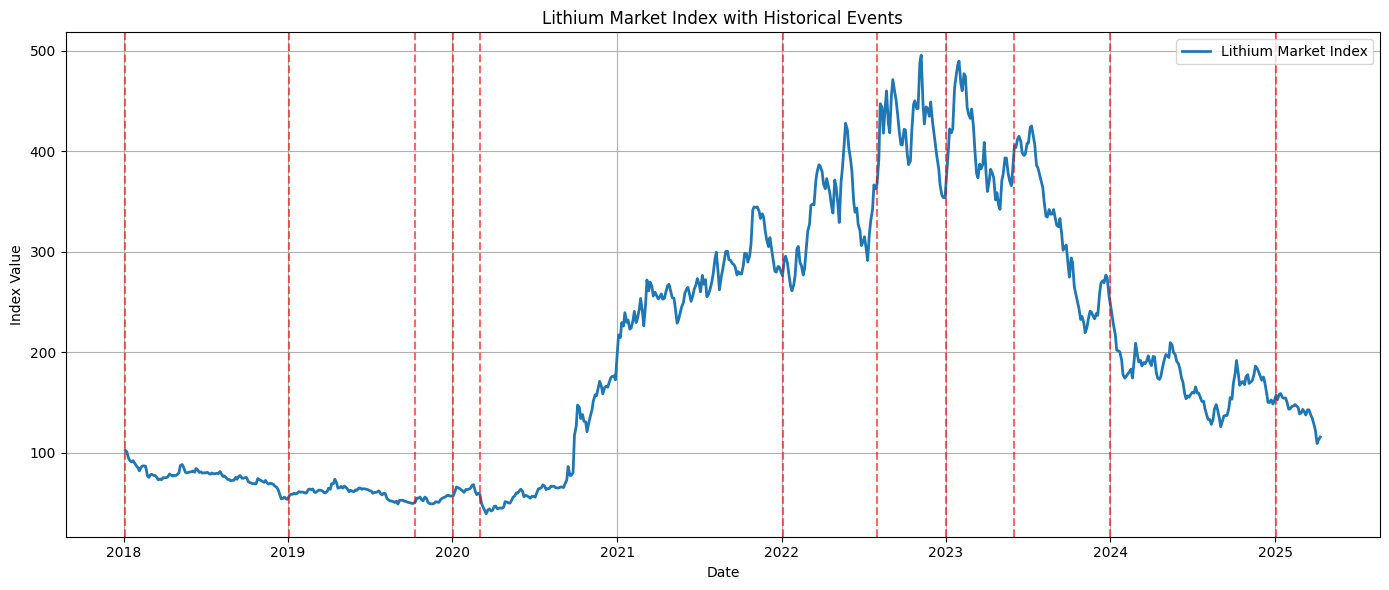

In [20]:
# Basic line plot
plt.figure(figsize=(14, 6))
plt.plot(returns_df.index, returns_df["Lithium_Market_Index"], label="Lithium Market Index", linewidth=2)

# Overlay event markers
for date in returns_df[returns_df["Has_Event"] == 1].index:
    plt.axvline(x=date, color="red", linestyle="--", alpha=0.6)

# Labels and styling
plt.title("Lithium Market Index with Historical Events")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../assets/img/li_index_with_historical_events.png', dpi=300)
plt.show()

In [21]:
returns_df.to_feather('../outputs/nb1_market_index_with_historical.feather')